# Description
This simulation generates scnearios (a path that a vehicle takes), and then uses a ""F

In [1]:
# All the imports we need
import numpy as np
import gtsam
from gtsam.utils.plot import plot_pose3
from matplotlib import pyplot as plt
from gtsam.symbol_shorthand import B, V, X
from gtbook.display import show
from mpl_toolkits.mplot3d import Axes3D
import time as t
from functools import partial
from error_functions import error_depth, error_dvl, error_unary_heading, error_gps
from time_sync_fixed import TimeSync
try:
  # For Google Colab
  from google.colab import output
  output.enable_custom_widget_manager()
  print(" -- Custom widgets enabled")
except:
  pass

# For interactive plots
%matplotlib widget

def gen_random_small_decimal():
   return np.random.randint(100) / 1000000

def vector3(x, y, z):
    """Create 3d double numpy array."""
    return np.array([x, y, z], dtype=float)


In [ ]:
T = 15  # The timespan of our trajectory.
dt = 1e-2  # 100 Hz frequency
velocity = np.array([2, 0, 0])  # The velocity we wish to move at.

scenarios = {
    "zero_twist": (np.zeros(3), np.zeros(3)),  # Zero motion, stationary trajectory.
    "forward_motion": (np.zeros(3), velocity),  # Move forward in the x axis at 2 m/s.
    "loop": (np.array([0., 0., -np.radians(5)]), velocity),  # A loop-de-loop trajectory.
    "sick": (np.array([np.radians(5), -np.radians(5), 0]), velocity)  # A spiral trajectory, "sick" in surfer slang.
}


def plot_scenario(scenario,
                  T,
                  dt,
                  title="IMU trajectory scenario",
                  fignum=0,
                  maxDim=5):
    for t in np.arange(0, T, dt):
        actualPose = scenario.pose(t)
        plot_pose3(fignum, actualPose, axis_length=0.3)

        translation = actualPose.translation()
        maxDim = max([max(np.abs(translation)), maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-maxDim, maxDim)
        ax.set_ylim3d(-maxDim, maxDim)
        ax.set_zlim3d(-maxDim, maxDim)
        ax.set_title(title)
    

    plt.show()

In [ ]:
# IMU Parameters

accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])

actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

pim_params = gtsam.PreintegrationParams.MakeSharedU(9.81)

# Some arbitrary noise sigmas
gyro_sigma = 1e-3
accel_sigma = 1e-3
I_3x3 = np.eye(3)
pim_params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
pim_params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
pim_params.setIntegrationCovariance(1e-7**2 * I_3x3)
g = 9.81
BIAS_COVARIANCE = gtsam.noiseModel.Isotropic.Variance(6, 0.1)


pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)



In [ ]:
# Unary stuff

# GPS -- in global frame
std_gps = 6
GPS_NOISE = gtsam.noiseModel.Isotropic.Sigma(3, std_gps) 
def get_gps_measurement(t, scenario):
    rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
    translationNoise = gtsam.Point3(*np.random.randn(3) * 0.1)
    poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
    gps_pose = scenario.navState(t).pose().compose(poseNoise)
    return gtsam.Point3(gps_pose.x(), gps_pose.y(), gps_pose.z())


# DVL -- note, for this simulation, the velocity values are assumed to have already been transformed to the global frame
std_dvl_vel = np.array([0.1, 0.1, 0.1])
DVL_NOISE = gtsam.noiseModel.Diagonal.Sigmas(std_dvl_vel)
def get_dvl_measurement(t, scenario):
    velocity = scenario.navState(t).velocity() + np.random.randn(3) * 0.1
    return velocity


# Heading - in global frame
std_orientation = np.deg2rad(3)
HEADING_NOISE = gtsam.noiseModel.Isotropic.Sigma(3, std_orientation)
def get_orientation_measurement(t, scenario):
    rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
    translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
    poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
    orientation_matrix = scenario.navState(t).pose().compose(poseNoise).rotation()
    return orientation_matrix

# Depth in global frames
std_depth = 0.1
DEPTH_NOISE = gtsam.noiseModel.Isotropic.Sigma(1, std_depth)
def get_depth_measurement(t, scenario):
    rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
    translationNoise = gtsam.Point3(*np.random.randn(3) * 0.1)
    poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
    gps_pose = scenario.navState(t).pose().compose(poseNoise)
    depth_meas = np.array([gps_pose.z()])
    return depth_meas






In [ ]:
def init_incremental_fixed_lag_smoother():
    # Incremental Fixed Lag Smoother Params
    isam_params = gtsam.ISAM2Params()
    isam_params.setRelinearizeThreshold(0.1)
    isam_params.relinearizeSkip = 1

    # important to set to true
    isam_params.findUnusedFactorSlots = True
    
    lag = 5.0 # the sliding window time frame    

    # key value to time_stamp
    time_stamp_map = gtsam.FixedLagSmootherKeyTimestampMap()

    return gtsam.IncrementalFixedLagSmoother(lag, isam_params), time_stamp_map





In [6]:
def add_priors(scenario, graph, initial, time_stamps, smoother):
    # Noise models for


    priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
    velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

    
    initial_state = scenario.navState(0)
    graph.push_back(
        gtsam.PriorFactorPose3(X(0), initial_state.pose(), priorNoise))
    
    graph.push_back(
        gtsam.PriorFactorVector(V(0), initial_state.velocity(), velNoise))

    graph.push_back(gtsam.PriorFactorConstantBias(B(0), actualBias, gtsam.noiseModel.Isotropic.Sigma(6, 0.1)))
    
    


    initial.insert(B(0), actualBias)
    initial.insert(X(0), initial_state.pose())
    initial.insert(V(0), initial_state.velocity())

    # fill time_stamp map
    time = 0.
    time_stamps[X(0)] = time
    time_stamps[V(0)] = time
    time_stamps[B(0)] = time
    

    smoother.update(graph, initial, time_stamps)
    result = smoother.calculateEstimate()
    # init things after update
    graph = gtsam.NonlinearFactorGraph()
    time_stamps = gtsam.FixedLagSmootherKeyTimestampMap()
    initial.clear()

    
    return graph, initial, smoother, result, initial_state, time_stamps





In [ ]:
def main_loop(runner, scenario, graph, initial, pim, time_stamps, smoother, T):

    ###########################################################
    ################## ROS 2 NODE INIT START ##################
    ###########################################################

    dt_gps = 1/1 # ~ 1 Hz
    dt_dvl = 1/6 # ~ 6 Hz
    dt_depth = 1/20 # ~ 20 Hz
    dt_orientation = 1/10 # ~ 10 Hz


     # queue's to be filled up
    q_gps = TimeSync()
    q_dvl = TimeSync()
    q_depth = TimeSync()
    q_orientation = TimeSync()


    # maps for times of estimates
    posekey_to_time = {}
    velkey_to_time = {}


    # The factor index for the estimation rate
    i = 0
    FACTOR_GRAPH_PERIOD = 1 # in seconds

  
    bias_key = B(0)


    # queus's
    pose_nodes_without_gps_unary = []
    pose_nodes_without_depth_unary = []
    pose_nodes_without_heading_unary = []
    vel_nodes_without_dvl_unary = []

    deployed = False

    ###########################################################
    ####################### ROS 2 NODE INIT END ###############
    ###########################################################



    for k, t in enumerate(np.arange(0, T, dt)):
        # get measurements and add them to PIM

        # IMU: simulating IMU ros2 callback at 100 Hz (Body frame)
        if deployed:
            measuredOmega = runner.measuredAngularVelocity(t)
            measuredAcc = runner.measuredSpecificForce(t)
            pim.integrateMeasurement(measuredAcc, measuredOmega, dt)
        # GPS: simulating gps ros2 subscriber (1 Hz)
        if k % int(dt_gps * int(1 / dt)) == 0 and deployed: # GPS every second, each k represents 100th of a second because IMU is at 100 Hz
            time_stamp_gps = t + gen_random_small_decimal()
            gps_meas = get_gps_measurement(t, scenario)
            q_gps.add_to_queue((gps_meas, time_stamp_gps)) # add a tuple with measurement and time
            # print('length of GPS: ', len(gps_scenario))

        # DVL: simulating dvl ros2 subscriber (6 Hz) (Global frame - DVL velocities should be transformed already)
        if k % int(dt_dvl * int(1 / dt)) == 0 and deployed: # dvl every 6th of a second (k = 60*n ticks)
            time_stamp_dvl = t + gen_random_small_decimal()
            dvl_meas = get_dvl_measurement(t, scenario)
            q_dvl.add_to_queue((dvl_meas, time_stamp_dvl))
            # print('length of DVL: ', len(dvl_scenario))

        # HEADING: simulating heading ros2 subscriber (10 Hz) (Global frame)
        if k % int(dt_orientation * int(1 / dt)) == 0 and deployed: # modem every 10th of a second (k = 10*n ticks)
            time_stamp_orientaion = t + gen_random_small_decimal()
            orient_meas = get_orientation_measurement(t, scenario)
            q_orientation.add_to_queue((orient_meas, time_stamp_orientaion))
            # print('length of orientation: ', len(orientation_scenario))

        # DEPTH: simulating depth ros2 subscriber (20 Hz) (Global Frame)
        if k % int(dt_depth * int(1 / dt)) == 0 and deployed: # depth every 20th of a second (k = 5*n ticks)
            time_stamp_depth = t + gen_random_small_decimal()
            depth_meas = get_depth_measurement(t, scenario)
            q_depth.add_to_queue((depth_meas, time_stamp_depth))
            # print('length of depth: ', len(depth_scenario))
        
        # ADD PRIOR CALLBACK: Simulating the add priors init factor graph callback
        if deployed == False:
            graph, initial, smoother, result, initial_state, time_stamps = add_priors(scenario, graph, initial, time_stamps, smoother)
            prev_state = initial_state
            deployed = True # so that you only add priors once



        # Factor graph timer callback
        if (k + 1) % int((1 / dt) * FACTOR_GRAPH_PERIOD) == 0:
        
            
            if i == 0:
                # GTSAM NavState
                predicted_state_imu_dead_reckoning = pim.predict(prev_state, actualBias)
                initial.insert(X(1), predicted_state_imu_dead_reckoning.pose())
                initial.insert(V(1), predicted_state_imu_dead_reckoning.velocity())
                prev_state = predicted_state_imu_dead_reckoning

                time_stamps[X(1)] = t
                time_stamps[V(1)] = t

                posekey_to_time[X(1)] = t
                velkey_to_time[V(1)] = t

                pose_nodes_without_depth_unary.append(X(1))
                pose_nodes_without_gps_unary.append(X(1))
                pose_nodes_without_heading_unary.append(X(1))
                vel_nodes_without_dvl_unary.append(V(1))
                
            elif i >= 2:
                # print(f'adding index {i}')
                predicted_state_imu_dead_reckoning = pim.predict(prev_state, actualBias)
                initial.insert(X(i), predicted_state_imu_dead_reckoning.pose())
                initial.insert(V(i), predicted_state_imu_dead_reckoning.velocity())
                prev_state = predicted_state_imu_dead_reckoning

                time_stamps[X(i)] = t
                time_stamps[V(i)] = t

                posekey_to_time[X(i)] = t
                velkey_to_time[V(i)] = t

                pose_nodes_without_depth_unary.append(X(i))
                pose_nodes_without_gps_unary.append(X(i))
                pose_nodes_without_heading_unary.append(X(i))
                vel_nodes_without_dvl_unary.append(V(i))


                

            if i > 0:
                # print(f'time @ index {i}: ', t + dt)

                if i % 2 == 0:
                    bias_key += 1
                    initial.insert(bias_key, actualBias)
                    # note that gtsam.imuBias.ConstantBias() defaults to zeroes
                    bias_between_factor = gtsam.BetweenFactorConstantBias(bias_key - 1, bias_key, gtsam.imuBias.ConstantBias(), BIAS_COVARIANCE)
                    graph.add(bias_between_factor)
                    time_stamps[bias_key] = t

                
                # Create IMU factor every second.

                # print('adding imu factor')
                factor = gtsam.ImuFactor(X(i - 1), V(i - 1), X(i), V(i), bias_key, pim)
                graph.push_back(factor)

                # We have created the binary constraint, so we clear out the preintegration values.
                pim.resetIntegration()

                
                if i > 2:
                    # Depth: constrain z estimate for pose
                    print('\n\nDepth Timesync')
                    pose_keys_unaries_tuples, pose_nodes_without_depth_unary = q_depth.time_match_unaries_to_nodes(pose_nodes_without_depth_unary, posekey_to_time, dt_depth)
                    while len(pose_keys_unaries_tuples) > 0:
                        measurement, key, _ = pose_keys_unaries_tuples.pop(0)
                        if abs(posekey_to_time[key] - t) <= smoother.smootherLag():
                            graph.add(gtsam.CustomFactor(DEPTH_NOISE, [key], partial(error_depth, [measurement])))

                    # GPS: constrain pose x y z estimate
                    print('\n\nGPS Time Sync')
                    pose_keys_unaries_tuples, pose_nodes_without_gps_unary = q_gps.time_match_unaries_to_nodes(pose_nodes_without_gps_unary, posekey_to_time, dt_gps)
                    while len(pose_keys_unaries_tuples) > 0:
                        measurement, key, _ = pose_keys_unaries_tuples.pop(0)
                        if abs(posekey_to_time[key] - t) <= smoother.smootherLag():
                            graph.add(gtsam.CustomFactor(GPS_NOISE, [key], partial(error_gps, measurement)))

                    # Heading Unaries: constrain orientation
                    print('\n\nHeading Time Sync')
                    pose_keys_unaries_tuples, pose_nodes_without_heading_unary = q_orientation.time_match_unaries_to_nodes(pose_nodes_without_heading_unary, posekey_to_time, dt_orientation)
                    while len(pose_keys_unaries_tuples) > 0:
                        measurement, key, _ = pose_keys_unaries_tuples.pop(0)
                        if abs(posekey_to_time[key] - t) <= smoother.smootherLag():
                            graph.add(gtsam.CustomFactor(HEADING_NOISE, [key],partial(error_unary_heading, [measurement])))
                    
                    # # DVL: Constrains velocity x y z
                    print('\n\nDVL Time Sync')
                    pose_keys_unaries_tuples, vel_nodes_without_dvl_unary = q_dvl.time_match_unaries_to_nodes(vel_nodes_without_dvl_unary, velkey_to_time, dt_dvl)
                    while len(pose_keys_unaries_tuples) > 0:
                        measurement, key, _ = pose_keys_unaries_tuples.pop(0)
                        if abs(velkey_to_time[key] - t) <= smoother.smootherLag():
                            graph.add(gtsam.CustomFactor(DVL_NOISE, [key], partial(error_dvl, measurement) ))


            i += 1

            smoother.update(graph, initial, time_stamps)
            result = smoother.calculateEstimate()
            graph = gtsam.NonlinearFactorGraph()
            time_stamps = gtsam.FixedLagSmootherKeyTimestampMap()
            initial.clear()

            

    return graph, result

In [8]:
def plot_trajectory(values: gtsam.Values,
                    title: str = "Estimated Trajectory",
                    fignum: int = 1,
                    show: bool = False):
    


    i = 0
    while values.exists(X(i)) == False:
        i += 1


    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))
        plot_pose3(fignum, pose_i, 1)
        i += 1
    plt.title(title)

    gtsam.utils.plot.set_axes_equal(fignum)

    plt.ioff()

    if show:
        plt.show()

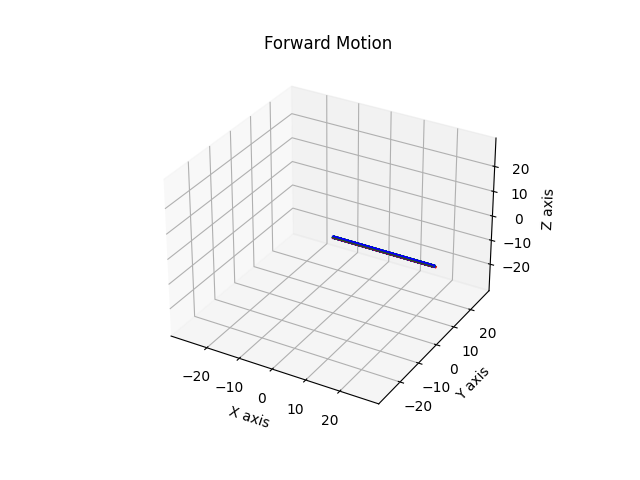



Depth Timesync
Time pairs synced (sensor time stamp to node time):
1.000064 : 0.99
3.000029 : 2.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
1.000085 : 0.99
3.000027 : 2.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
1.000098 : 0.99
3.000017 : 2.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
0.960067 : 0.99
3.040021 : 2.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
4.000095 : 3.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
4.00002 : 3.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
4.000053 : 3.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
5.000081 : 4.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
4.000007 : 3.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
5.000043 : 4.99


DVL Time Syn

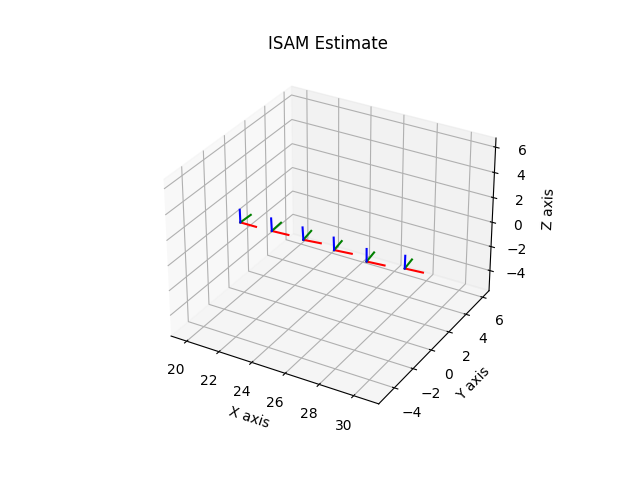

In [9]:

scenario = gtsam.ConstantTwistScenario(*scenarios["forward_motion"])
plot_scenario(scenario, T, dt, title="Forward Motion", fignum=5)
runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)
# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)

graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
smoother, time_stamps = init_incremental_fixed_lag_smoother()
graph, result = main_loop(runner, scenario, graph, initial,pim, time_stamps, smoother, T)
print(result)

plot_trajectory(result, title="ISAM Estimate", fignum=7, show=True)

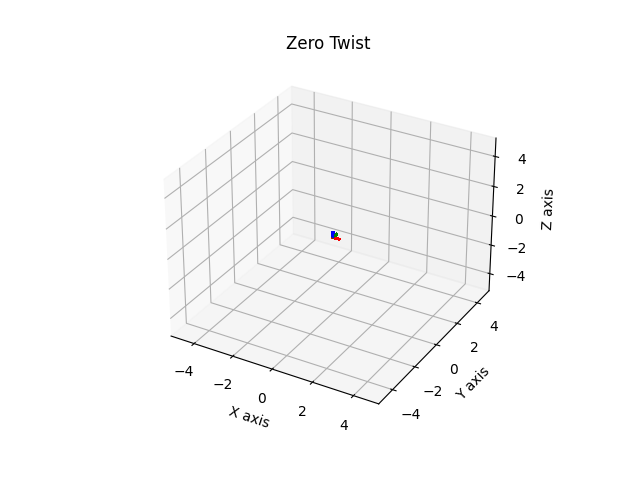



Depth Timesync
Time pairs synced (sensor time stamp to node time):
1.000045 : 0.99
3.000044 : 2.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
1.000018 : 0.99
3.00006 : 2.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
1.000058 : 0.99
3.000015 : 2.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
0.9600989999999999 : 0.99
3.04 : 2.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
4.000061 : 3.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
4.000036 : 3.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
4.000084 : 3.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
5.000019 : 4.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
4.000047 : 3.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
5.000088 : 4.99


DVL Ti

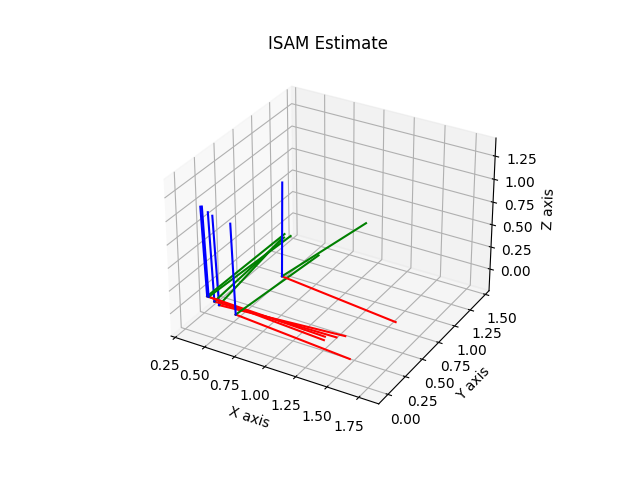

In [10]:
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)
scenario = gtsam.ConstantTwistScenario(*scenarios["zero_twist"])
plot_scenario(scenario, T, dt, title="Zero Twist", fignum=8)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

smoother, time_stamps = init_incremental_fixed_lag_smoother()
graph, result = main_loop(runner, scenario, graph, initial,pim, time_stamps, smoother, T)
plot_trajectory(result, title="ISAM Estimate", fignum=9, show=True)



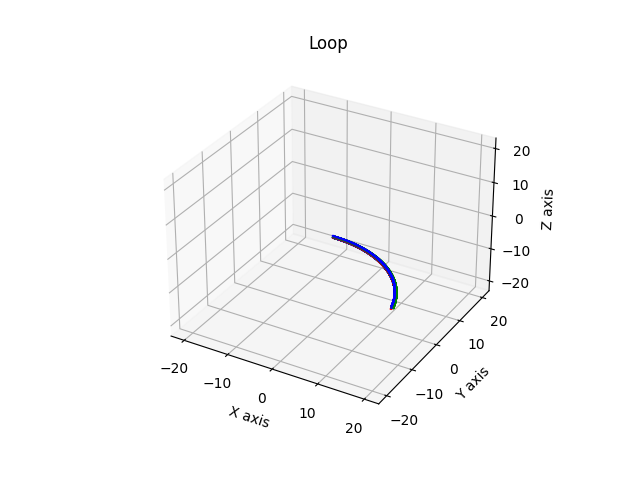



Depth Timesync
Time pairs synced (sensor time stamp to node time):
1.000022 : 0.99
3.000014 : 2.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
1.000081 : 0.99
3.00008 : 2.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
1.000019 : 0.99
3.000049 : 2.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
0.9600529999999999 : 0.99
3.040004 : 2.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
4.000096 : 3.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
4.000079 : 3.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
4.000096 : 3.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
5.000066 : 4.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
4.000026 : 3.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
5.000017 : 4.99


DV

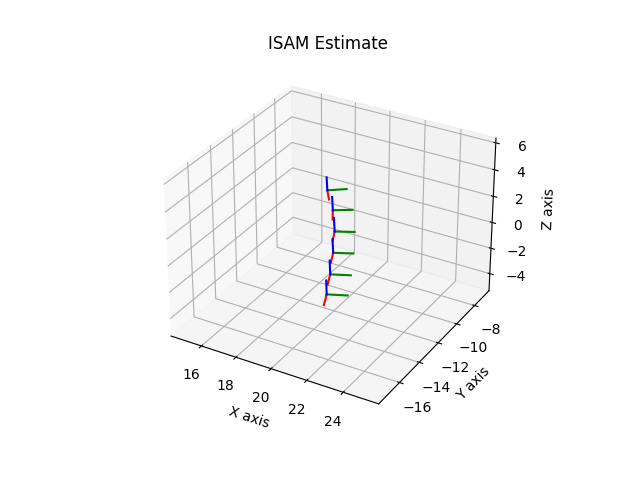

In [11]:
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)

scenario = gtsam.ConstantTwistScenario(*scenarios["loop"])
plot_scenario(scenario, T, dt, title="Loop", fignum=10)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
smoother, time_stamps = init_incremental_fixed_lag_smoother()
graph, result = main_loop(runner, scenario, graph, initial,pim, time_stamps, smoother, T)
plot_trajectory(result, title="ISAM Estimate", fignum=11, show=True)

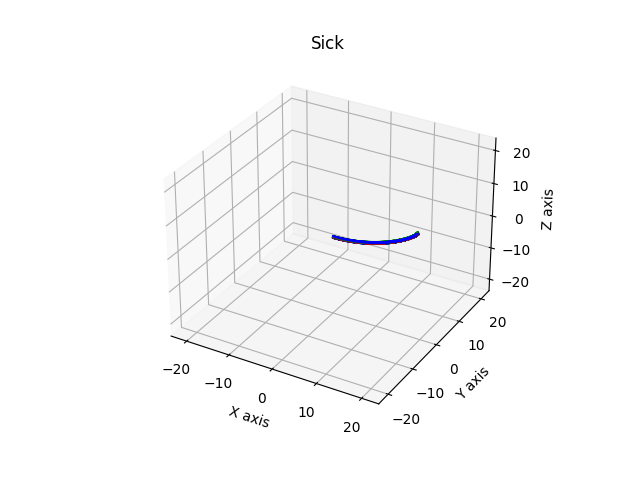



Depth Timesync
Time pairs synced (sensor time stamp to node time):
1.000068 : 0.99
3.000001 : 2.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
1.000002 : 0.99
3.000028 : 2.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
1.000073 : 0.99
3.000061 : 2.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
0.960025 : 0.99
3.040013 : 2.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
4.000004 : 3.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
4.000071 : 3.99


DVL Time Sync
Time pairs synced (sensor time stamp to node time):
4.000025 : 3.99


Depth Timesync
Time pairs synced (sensor time stamp to node time):
5.000067 : 4.99


GPS Time Sync
Time pairs synced (sensor time stamp to node time):
4.000025 : 3.99


Heading Time Sync
Time pairs synced (sensor time stamp to node time):
5.000003 : 4.99


DVL Time Sy

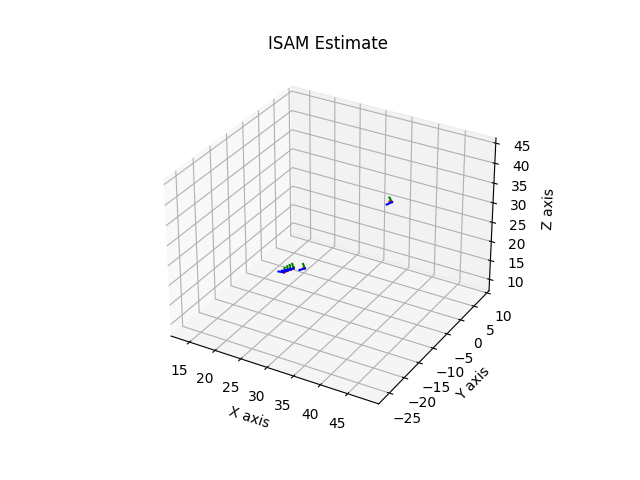

In [12]:
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)
scenario = gtsam.ConstantTwistScenario(*scenarios["sick"])
plot_scenario(scenario, T, dt, title="Sick", fignum=12)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
smoother, time_stamps = init_incremental_fixed_lag_smoother()
graph, result = main_loop(runner, scenario, graph, initial,pim, time_stamps, smoother, T)
plot_trajectory(result, title="ISAM Estimate", fignum=13, show=True)